# Load libraries

In [25]:
import pickle
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from joblib import load
from treeinterpreter import treeinterpreter as ti

# Define general variables

In [2]:
seed = 0

# Get own model predictions

In [3]:
# load model
a_file = open("../../experiments/comparingModels/seed" + str(seed) + "/ownModel/testOwnModelPredictions.pkl", "rb")
ownModelResults = pickle.load(a_file)
print(ownModelResults.keys())
print(ownModelResults["testIds"].shape)

dict_keys(['testIds', 'testLabels', 'testPredictions'])
(6546,)


# Get RF predictions

In [4]:
# load files
a_file = open("../../experiments/comparingModels/seed" + str(seed) + "/RF/testPredictionsRF.pkl", "rb")
rFResults = pickle.load(a_file)
print(rFResults.keys())
print(rFResults["testIds"].shape)

dict_keys(['testIds', 'testLabels', 'testPredictions'])
(6546,)


# Test if test datasets are equals

In [5]:
assert np.array_equal(ownModelResults["testIds"], rFResults["testIds"])
print("test ok")

test ok


In [6]:
assert np.array_equal(ownModelResults["testLabels"], rFResults["testLabels"])
print("test ok")

test ok


In [7]:
assert not np.array_equal(ownModelResults["testPredictions"], rFResults["testPredictions"])
print("test ok")

test ok


# Analysis

# get confusion matrix

In [8]:
# ["true", "pred", "all", None]
normalize = None

RF model
class 0: [137   0   0   5   3   0]


<AxesSubplot:>

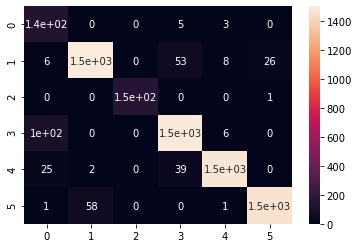

In [9]:
print("RF model")

# get confussion matrix
# C_ij such that  is equal to the number of observations known to be in group i and predicted to be in group j
rFResultsCM = confusion_matrix(
    rFResults["testLabels"], 
    rFResults["testPredictions"], 
    normalize = normalize
)

print(f"class 0: {rFResultsCM[0, :]}")

# plot
sn.heatmap(rFResultsCM, annot=True)

Own model
class 0: [113   6   0  13  10   3]


<AxesSubplot:>

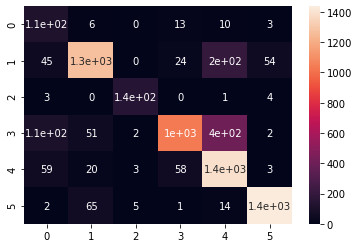

In [10]:
print("Own model")

# get confussion matrix
# C_ij such that  is equal to the number of observations known to be in group i and predicted to be in group j
ownModelCM = confusion_matrix(ownModelResults["testLabels"], ownModelResults["testPredictions"], normalize = normalize)

print(f"class 0: {ownModelCM[0, :]}")

# plot
sn.heatmap(ownModelCM, annot=True)

# Get classification report

In [11]:
print("RF model")
print(classification_report(rFResults["testLabels"], rFResults["testPredictions"]))

RF model
              precision    recall  f1-score   support

         6.0       0.50      0.94      0.66       145
        16.0       0.96      0.94      0.95      1593
        53.0       1.00      0.99      1.00       149
        65.0       0.94      0.93      0.94      1598
        88.0       0.99      0.96      0.97      1537
        92.0       0.98      0.96      0.97      1524

    accuracy                           0.95      6546
   macro avg       0.90      0.95      0.91      6546
weighted avg       0.96      0.95      0.95      6546



In [12]:
print("own model")
print(classification_report(ownModelResults["testLabels"], ownModelResults["testPredictions"]))

own model
              precision    recall  f1-score   support

         6.0       0.34      0.78      0.48       145
        16.0       0.90      0.80      0.85      1593
        53.0       0.93      0.95      0.94       149
        65.0       0.92      0.65      0.76      1598
        88.0       0.69      0.91      0.78      1537
        92.0       0.96      0.94      0.95      1524

    accuracy                           0.82      6546
   macro avg       0.79      0.84      0.79      6546
weighted avg       0.86      0.82      0.83      6546



# Get how many correct and wrong classifications are done by each model?
Add this to the paper

In [13]:

# save correct classifications by each model 
# shape: (classes, models (2: own and RF))
correctClassifications = np.zeros(shape  = (6, 2))

wrongClassifications = np.zeros(shape = (6,2))

# iterate by each class
for i in np.arange(6):
    
    # RF
    correctClassifications[i][0] = rFResultsCM[i][i] / np.sum(rFResultsCM[i])
    wrongClassifications[i][0] = np.sum(rFResultsCM[i][np.delete(np.arange(6), i)]) / np.sum(rFResultsCM[i])
    
    # own model
    correctClassifications[i][1] = ownModelCM[i][i] / np.sum(ownModelCM[i])
    wrongClassifications[i][1] = np.sum(ownModelCM[i][np.delete(np.arange(6), i)]) / np.sum(ownModelCM[i])

In [14]:
print("Correct classifications. 0: RF")
correctClassifications

Correct classifications. 0: RF


array([[0.94482759, 0.77931034],
       [0.94161959, 0.79849341],
       [0.99328859, 0.94630872],
       [0.93178974, 0.64768461],
       [0.95705921, 0.90696161],
       [0.96062992, 0.94291339]])

In all classes, RF is better

In [15]:
print("Wrong classifications. 0: RF")
wrongClassifications

Wrong classifications. 0: RF


array([[0.05517241, 0.22068966],
       [0.05838041, 0.20150659],
       [0.00671141, 0.05369128],
       [0.06821026, 0.35231539],
       [0.04294079, 0.09303839],
       [0.03937008, 0.05708661]])

In all classes, RF is better

Based on resutls, RF is better in all classes. There is no one class our model is better, so the models are not complementaries. Our model does not add more value to the classification.

# Get examples wrongly classified by own model but correctly by RF

In [16]:
# get RF samples who predictions are equals to labels
maskRFCorrects = (rFResults["testPredictions"] == ownModelResults["testLabels"])

# get OM samples who predictions are not equals to labels
maskOwnModelWrong = (ownModelResults["testPredictions"] != ownModelResults["testLabels"])

# get ids that 1)RF are corrects 2) ON are wrong
finalMask = (maskRFCorrects & maskOwnModelWrong)

# get ids samples
idsRFCorrectsAndOwnModelWrongs = ownModelResults["testIds"][finalMask]
labelsRFCorrectsAndOwnModelWrongs = ownModelResults["testLabels"][finalMask]

# # build object
# samplesRFCorrectsAndOwnModelWrongs = {
#     "ids": idsRFCorrectsAndOwnModelWrongs,
#     "labels": ownModelResults["testLabels"][finalMask]
# }

In [17]:
idsRFCorrectsAndOwnModelWrongs.shape

(979,)

In [18]:
# test if RF is correct classified and Own model is wrong
for i in idsRFCorrectsAndOwnModelWrongs:
    
    index = np.where(ownModelResults["testIds"]  == i)[0][0]
    
    # test
    # 1) if RF is classifiying correctly
    # 2) if Own model is classifiying wrongly
    assert ownModelResults["testLabels"][index] == rFResults["testPredictions"][index] and ownModelResults["testLabels"][index] != ownModelResults["testPredictions"][index]

In [19]:
np.unique(labelsRFCorrectsAndOwnModelWrongs, return_counts = True)

(array([ 6., 16., 53., 65., 88., 92.]), array([ 26, 254,   7, 520, 127,  45]))

<BarContainer object of 6 artists>

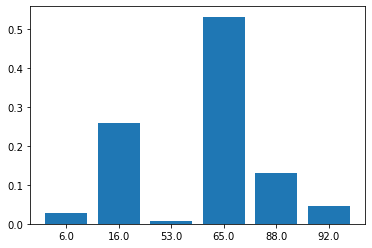

In [20]:
# analyze labels distributions
fig, ax = plt.subplots()

classes, countClasses = np.unique(labelsRFCorrectsAndOwnModelWrongs, return_counts = True)

countClasses = countClasses / np.sum(countClasses)

classes = list(map(str, classes))

ax.bar(
    classes, 
    countClasses,
#     width = 10,
)

# Get features RF uses to classify them

In [81]:
# get RF model
# # load file
rf = load('../../experiments/comparingModels/seed' + str(seed) + '/RF/trainedRF.joblib') 

In [22]:
# loading features names
seed = 0
with open(f"../random_forest/ids/seed{seed}/maxClass15k/dataset_ids_before_balancing.pkl", "rb") as f:
    lc_ids = pickle.load(f)

with open("../random_forest/features/fats"+str(int(lc_ids["train"][0]))+".pkl", "rb") as f:
    tmp = load(f)
    
    # get features names
    featuresNames = tmp.columns.values

<BarContainer object of 20 artists>

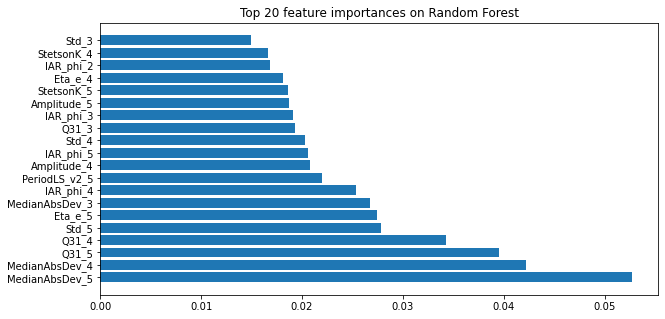

In [23]:
# FATS computing: https://github.com/isadoranun/FATS/blob/master/FATS/FeatureFunctionLib.py

# get the most important features
featuresByImportance, importance = featuresNames[np.argsort(rf.feature_importances_)[::-1]], rf.feature_importances_[np.argsort(rf.feature_importances_)[::-1]]

featuresToDisplay = 20

fig, ax = plt.subplots(figsize = (10, 5))

ax.set_title(f"Top {featuresToDisplay} feature importances on Random Forest")
ax.barh(featuresByImportance[:featuresToDisplay], importance[:featuresToDisplay])

# Get decomposition of predictions on correct RF and wrong OM

In [124]:
# (node_indicator, _) = rf.decision_path(instances)

# node_indicator

# Extract single tree
estimator = rf.estimators_

# len(estimator)

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator[5], 
                out_file='tree.dot', 
                feature_names = featuresNames,
#                 class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')
# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

FileNotFoundError: [Errno 2] No such file or directory: 'dot': 'dot'

In [102]:
# get data
id_ = idsRFCorrectsAndOwnModelWrongs[1]

index = np.where(ownModelResults["testIds"]  == id_)[0][0]

print(f"label: {ownModelResults['testLabels'][index]}")

print(f"RF prediction: {rFResults['testPredictions'][index]}")

with open("../random_forest/features/fats"+ str(round(id_)) +".pkl", "rb") as f:
    instances = load(f)

#get predictions
prediction, bias, contributions = ti.predict(rf, instances)

# prediction = rf.predict(instances)

only_these_labels = [16, 92, 53, 88, 65, 6]

print(only_these_labels[np.argmax(prediction)])

label: 88.0
RF prediction: 88
65


In [100]:
print(prediction)

print(np.argmax(prediction))

[[0.20052328 0.09406491 0.00284883 0.02324763 0.670528   0.00878735]]
4


In [95]:
# get decomposition
for i in range(len(instances)):
    
    print("Instance", i)
    print("Bias (trainset mean", bias[i])
    print("Feature contributions:")
#     for c, feature in sorted(zip(contributions[i], featuresNames), key=lambda x: -abs(x[0])):
#         print(feature, round(c, 2))
    for c, feature in zip(contributions[0], 
                             featuresNames):
        print(feature)
        print(c)
        
    print("-"*20)

Instance 0
Bias (trainset mean [0.42528458 0.038766   0.41640482 0.03871296 0.0401875  0.04064415]
Feature contributions:
CAR_sigma_0
[ 2.06187155e-03 -2.54053891e-04  6.77357169e-05 -1.31096528e-04
 -1.37509700e-03 -3.69359847e-04]
CAR_mean_0
[ 0.00000000e+00  8.66863717e-04  0.00000000e+00 -6.76108608e-04
 -1.76580774e-04 -1.41743342e-05]
Meanvariance_0
[ 9.35231971e-04 -5.00379236e-05  0.00000000e+00 -4.11040630e-04
 -4.74153417e-04  0.00000000e+00]
Mean_0
[ 1.26988949e-04 -3.18519844e-05  0.00000000e+00 -2.91583871e-05
 -6.59785779e-05  0.00000000e+00]
PercentAmplitude_0
[-4.20116456e-04  2.17751163e-04  0.00000000e+00  8.51735411e-05
  9.19096025e-05  2.52821487e-05]
Skew_0
[ 3.22939711e-04  1.74547923e-04  0.00000000e+00  2.77846703e-05
  1.25451366e-04 -6.50723670e-04]
AndersonDarling_0
[-1.33781343e-03  6.68243463e-04  0.00000000e+00  6.39814411e-04
  1.48139797e-05  1.49415711e-05]
Std_0
[ 0.00275055 -0.00277488  0.00016648 -0.00072756 -0.0004506   0.00103601]
Rcs_0
[ 2.502049

In [101]:
ti.predict?